In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import nltk
import numpy as np
import re
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve, auc, PrecisionRecallDisplay, RocCurveDisplay, mean_squared_error)
from sklearn.dummy import DummyClassifier
from scipy import stats
import pickle

In [2]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=8) 
plt.rc('axes', titlesize=8) 
plt.rc('axes', labelsize=8) 
plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
plt.rc('legend', fontsize=8)
%config InlineBackend.figure_format = 'retina'
pd.options.display.float_format = '{:.0f}'.format

In [3]:
df = pd.read_csv('./../datasets/oal_doc_dataset_extended.csv', 
                 names=['doi', 'pm_grouptype', 'type', 'abstract', 'title', 'page', 'author_count',
                          'has_license', 'is_referenced_by_count',
                          'references_count', 'has_funder', 'country_count', 'inst_count', 'has_oa_url'],
                 dtype={'doi': str,
                        'pm_grouptype': str,
                        'type': str,
                        'abstract': str,
                        'title': str,
                        'page': str,
                        'author_count': int,
                        'has_license': int,
                        'is_referenced_by_count': int,
                        'references_count': int,
                        'has_funder': int,
                        'country_count': int,
                        'inst_count': int,
                        'has_oa_url': int
                 }, sep=',', quotechar='"', header=0)

In [4]:
df_publisher = pd.read_csv('./../datasets/cr_publisher.csv', sep=',')

In [5]:
df.head()

,doi,pm_grouptype,type,abstract,title,page,author_count,has_license,is_referenced_by_count,references_count,has_funder,country_count,inst_count,has_oa_url
0,10.1001/2012.jama.10425,Journal_Article,research_discourse,NaN,A Path to Wholeness,985,4,0,1,0,0,1,1,0
1,10.1001/2012.jama.10452,Journal_Article,research_discourse,NaN,Worries,873,1,0,1,0,0,1,1,0
2,10.1001/2012.jama.10500,News,editorial_discourse,NaN,Critics of US House Proposal to Ax AHRQ Say Id...,849,1,0,0,0,0,1,1,0
3,10.1001/2012.jama.10931,Editorial,editorial_discourse,NaN,Atherogenic Vascular Stiffness and Hypertension,919,1,0,11,0,0,1,1,0
4,10.1001/2012.jama.10939,News,editorial_discourse,NaN,Lessons From Massachusetts: Cost Remains a Hur...,961,1,0,1,0,0,1,1,0


In [6]:
def page_counter(page_str):
    page_int = 1
    if '-' in str(page_str):
        try:
            page_str = re.sub(r'(\.e)[\d]*', '', page_str)
            page_str = re.sub(r'(\.)[\d]*', '', page_str)
            page_str = re.sub(r'(?<=\d)(e)(\d)*', '', page_str)
            page_str = re.sub(r'[^\d-]', '', page_str)
            #page_str = re.sub(r'(S)[\d]-', '', page_str)
            page_int = int(abs(eval(page_str)))
            if page_int != 1:
                page_int += 1
        except:
            pass
        
    return page_int

In [7]:
df['page_count'] = df.page.apply(page_counter)
df['page_count'] = df['page_count'].astype(int)

In [8]:
df['title_word_length'] = df['title'].str.split().str.len()
#df['abstract_word_length']  = df['abstract'].str.split().str.len()

In [9]:
#df['title_string_length']  = df['title'].str.len()
#df['abstract_string_length']  = df['abstract'].str.len()

In [10]:
def has_abstract(abstract_str):
    if pd.isna(abstract_str):
        return 0
    else:
        return 1

In [11]:
df['has_abstract'] = df.abstract.apply(has_abstract)
df['has_abstract'] = df['has_abstract'].astype(int)

In [12]:
#df['title_string_length'] = df['title_string_length'].fillna(0)
#df['abstract_string_length'] = df['abstract_string_length'].fillna(0)
df['title_word_length'] = df['title_word_length'].fillna(0)
#df['abstract_word_length'] = df['abstract_word_length'].fillna(0)

In [13]:
df = df[df['type'] != 'not assigned']
df['type'] = df['type'].replace(to_replace='research_discourse', value=1)
df['type'] = df['type'].replace(to_replace='editorial_discourse', value=0)
df['type'] = df['type'].astype(int)
df = df.reset_index(drop=True)

In [14]:
#df = df[(np.abs(stats.zscore(df[['author_count', 
#                                 'is_referenced_by_count', 
#                                 'references_count', 
#                                 'page_count', 
#                                 'title_word_length']])) < 3).all(axis=1)]

In [15]:
df_with_publisher = df.merge(df_publisher, on=['doi'])

In [16]:
df_pub_n = df_with_publisher.groupby(['publisher'])['doi'].count().reset_index().sort_values(by=['doi'], ascending=False)
df_pub_n.columns = ['publisher', 'n']

In [17]:
df_pub_n = df_pub_n[df_pub_n.n > 5000]
df = df_with_publisher.merge(df_pub_n, on=['publisher'])

In [18]:
#df.drop_duplicates(subset=['type', 'author_count', 'has_license', 'is_referenced_by_count',
#                           'references_count', 'has_funder', 'page_count', 'has_abstract', 
#                           'title_word_length', 'has_oa_url', 'country_count'], ignore_index=True, inplace=True)
#len(df)

In [19]:
X = df[['doi', 'author_count', 'has_license', 'is_referenced_by_count',
        'references_count', 'has_funder', 'page_count', 'has_abstract', 'title_word_length', 'inst_count', 'has_oa_url']].values
y = df[['type']].values.ravel()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

In [21]:
test_df = pd.DataFrame(X_test, columns=['doi', 'author_count', 'has_license', 'is_referenced_by_count',
                                        'references_count', 'has_funder', 'page_count', 'has_abstract', 'title_word_length', 'inst_count', 'has_oa_url'])
X = np.delete(X, 0, 1)
X_train = np.delete(X_train, 0, 1)
X_test = np.delete(X_test, 0, 1)

## LogisticRegression

In [22]:
classifier = LogisticRegression(max_iter=1000, random_state=42)
classifier.fit(X_train, y_train)
 
y_pred = classifier.predict(X_test)

In [23]:
print(classification_report(y_test, y_pred, zero_division=1, target_names=['editorial_discourse', 'research_discourse']))

                     precision    recall  f1-score   support

editorial_discourse       0.60      0.30      0.40    169709
 research_discourse       0.95      0.98      0.96   2121196

           accuracy                           0.93   2290905
          macro avg       0.77      0.64      0.68   2290905
       weighted avg       0.92      0.93      0.92   2290905



## OpenAlex

In [24]:
df_oal_test = pd.read_csv('datasets/oal_doctype_testset.csv')
df_oal_test = df_oal_test[df_oal_test['oaltype'] != 'not assigned']
df_oal_test = df_oal_test.reset_index(drop=True)

In [25]:
df_oal_test = df[['doi', 'type']].merge(df_oal_test, on=['doi'])
#df_oal_test = test_df[['doi']].merge(df_oal_test, on=['doi'])

In [26]:
df_oal_test['oaltype'] = df_oal_test['oaltype'].replace(to_replace='research_discourse', value=1)
df_oal_test['oaltype'] = df_oal_test['oaltype'].replace(to_replace='editorial_discourse', value=0)
#df_oal_test['oaltype'] = df_oal_test['oaltype'].replace(to_replace='not assigned', value=0)

In [27]:
y_pm = df_oal_test[['type']].values.ravel()
y_oal = df_oal_test[['oaltype']].values.ravel()

In [28]:
print(classification_report(y_pm, y_oal, zero_division=1, target_names=['editorial_discourse', 'research_discourse']))

                     precision    recall  f1-score   support

editorial_discourse       0.90      0.05      0.10    678783
 research_discourse       0.93      1.00      0.96   8484193

           accuracy                           0.93   9162976
          macro avg       0.91      0.53      0.53   9162976
       weighted avg       0.93      0.93      0.90   9162976



## Scopus

In [29]:
df_scp_test = pd.read_csv('datasets/scp_doctype_testset.csv')
df_scp_test = df_scp_test[df_scp_test['scptype'] != 'not assigned']
df_scp_test = df_scp_test.reset_index(drop=True)

In [30]:
df_scp_test = df[['doi', 'type']].merge(df_scp_test, on=['doi'])
#df_scp_test.drop_duplicates(subset='doi', keep='last', inplace=True, ignore_index=False)
#df_scp_test = test_df[['doi']].merge(df_scp_test, on=['doi'])

In [31]:
df_scp_test['scptype'] = df_scp_test['scptype'].replace(to_replace='research_discourse', value=1)
df_scp_test['scptype'] = df_scp_test['scptype'].replace(to_replace='editorial_discourse', value=0)
#df_scp_test['scptype'] = df_scp_test['scptype'].replace(to_replace='not assigned', value=0)

In [32]:
y_spm = df_scp_test[['type']].values.ravel()
y_scp = df_scp_test[['scptype']].values.ravel()

In [33]:
print(classification_report(y_spm, y_scp, zero_division=1, target_names=['editorial_discourse', 'research_discourse']))

                     precision    recall  f1-score   support

editorial_discourse       0.65      0.87      0.74    484580
 research_discourse       0.99      0.97      0.98   8368071

           accuracy                           0.97   8852651
          macro avg       0.82      0.92      0.86   8852651
       weighted avg       0.97      0.97      0.97   8852651



## Dummy

In [34]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X, y)

y_pred = dummy_clf.predict(X)
print(classification_report(y, y_pred, zero_division=1, target_names=['editorial_discourse', 'research_discourse']))

                     precision    recall  f1-score   support

editorial_discourse       0.07      0.07      0.07    678835
 research_discourse       0.93      0.93      0.93   8484785

           accuracy                           0.86   9163620
          macro avg       0.50      0.50      0.50   9163620
       weighted avg       0.86      0.86      0.86   9163620



In [35]:
## RandomForest

In [36]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(criterion='gini', max_depth=None, max_features='sqrt', n_estimators=200, n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)
 
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=1, target_names=['editorial_discourse', 'research_discourse']))

                     precision    recall  f1-score   support

editorial_discourse       0.63      0.60      0.62    169709
 research_discourse       0.97      0.97      0.97   2121196

           accuracy                           0.94   2290905
          macro avg       0.80      0.79      0.79   2290905
       weighted avg       0.94      0.94      0.94   2290905



In [37]:
importances = clf.feature_importances_

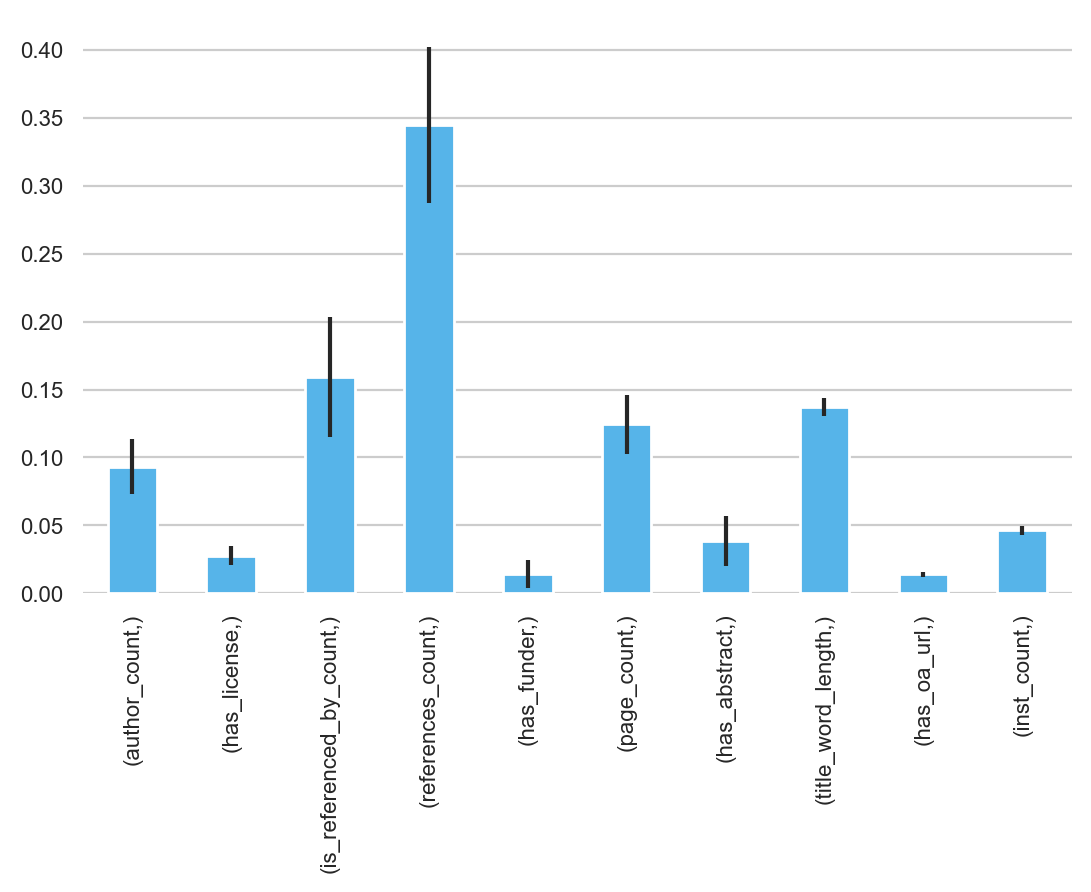

In [38]:
forest_importances = pd.Series(importances, index=[['author_count', 'has_license', 'is_referenced_by_count',
        'references_count', 'has_funder', 'page_count', 'has_abstract', 'title_word_length', 'has_oa_url', 'inst_count']])
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(5.5,4.5))
plt.box(False)
forest_importances.plot.bar(yerr=std, ax=ax, color='#56B4E9')
ax.xaxis.grid(False)
fig.tight_layout()
plt.show()
fig.savefig('media/clf_importances.png', format='png', bbox_inches='tight', dpi=500)

## KNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50, 
                           weights='uniform', 
                           algorithm='auto',
                           leaf_size=30, 
                           p=1, 
                           n_jobs=-1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=1, target_names=['editorial_discourse', 'research_discourse']))

                     precision    recall  f1-score   support

editorial_discourse       0.65      0.61      0.63    169709
 research_discourse       0.97      0.97      0.97   2121196

           accuracy                           0.95   2290905
          macro avg       0.81      0.79      0.80   2290905
       weighted avg       0.95      0.95      0.95   2290905



In [ ]:
cv = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [ ]:
from numpy import mean, std
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

In [ ]:
scores

In [40]:
elsevier = df_with_publisher[df_with_publisher.publisher == 'Elsevier BV']
wiley = df_with_publisher[df_with_publisher.publisher == 'Wiley']
springer = df_with_publisher[df_with_publisher.publisher == 'Springer Science and Business Media LLC']
ovid = df_with_publisher[df_with_publisher.publisher == 'Ovid Technologies (Wolters Kluwer Health)']
ama = df_with_publisher[df_with_publisher.publisher == 'American Medical Association (AMA)']
oup = df_with_publisher[df_with_publisher.publisher == 'Oxford University Press (OUP)']
mdpi = df_with_publisher[df_with_publisher.publisher == 'MDPI AG']
informa = df_with_publisher[df_with_publisher.publisher == 'Informa UK Limited']

In [84]:
pd.reset_option('float_format')

In [42]:
elsevier[['author_count', 'has_license', 'is_referenced_by_count',
         'references_count', 'has_funder', 'page_count', 'has_abstract', 'title_word_length', 'has_oa_url', 'country_count']].mean()

author_count               6.263030
has_license                0.980656
is_referenced_by_count    26.107320
references_count          43.197442
has_funder                 0.425529
page_count                 6.554339
has_abstract               0.000057
title_word_length         13.971728
has_oa_url                 0.400655
country_count              1.326387
dtype: float64

In [43]:
wiley[['author_count', 'has_license', 'is_referenced_by_count',
         'references_count', 'has_funder', 'page_count', 'has_abstract', 'title_word_length', 'has_oa_url', 'country_count']].mean()

author_count               5.966120
has_license                0.993594
is_referenced_by_count    21.850300
references_count          43.171674
has_funder                 0.421691
page_count                 7.877176
has_abstract               0.813764
title_word_length         13.767230
has_oa_url                 0.494479
country_count              1.369115
dtype: float64

In [44]:
informa[['author_count', 'has_license', 'is_referenced_by_count',
         'references_count', 'has_funder', 'page_count', 'has_abstract', 'title_word_length', 'has_oa_url', 'country_count']].mean()

author_count               5.276146
has_license                0.239789
is_referenced_by_count    14.587955
references_count          40.061982
has_funder                 0.265226
page_count                 9.162111
has_abstract               0.006592
title_word_length         14.014389
has_oa_url                 0.478602
country_count              1.290286
dtype: float64

In [45]:
springer[['author_count', 'has_license', 'is_referenced_by_count',
         'references_count', 'has_funder', 'page_count', 'has_abstract', 'title_word_length', 'has_oa_url', 'country_count']].mean()

author_count               6.876902
has_license                0.938849
is_referenced_by_count    26.636369
references_count          42.934946
has_funder                 0.323178
page_count                 5.589068
has_abstract               0.287537
title_word_length         14.173542
has_oa_url                 0.650366
country_count              1.335450
dtype: float64

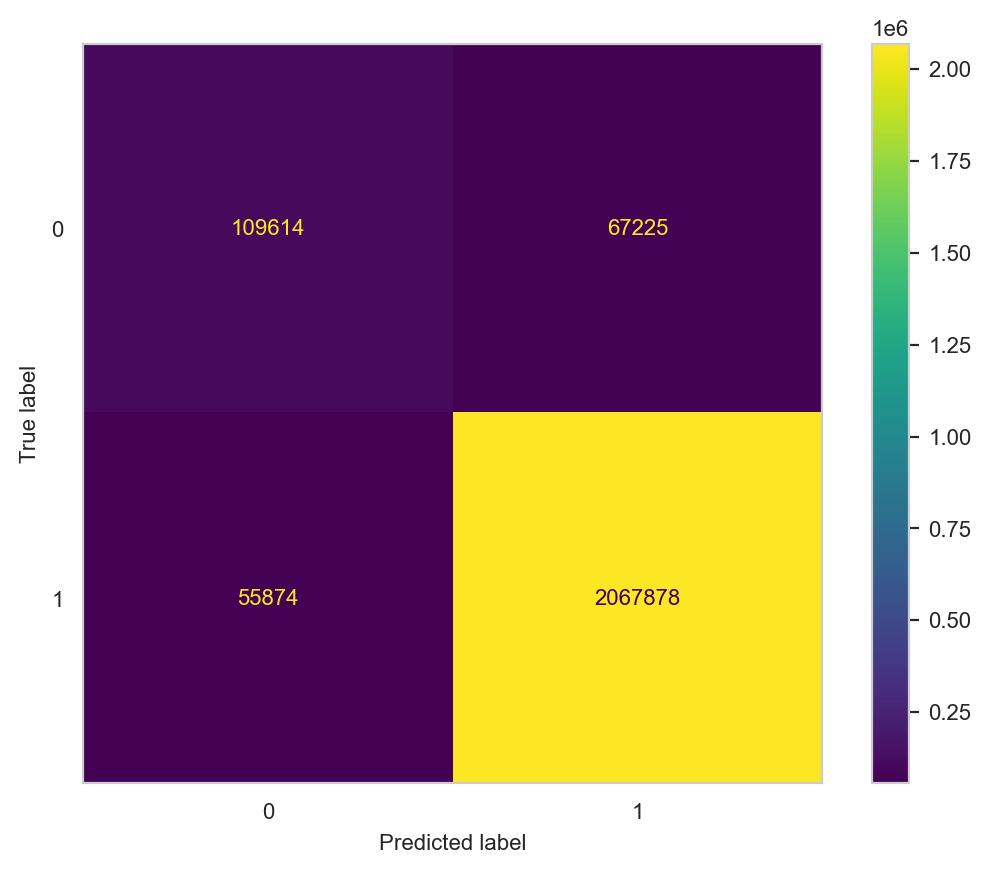

In [46]:
# y_pred = knn.predict(X)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, labels=[0, 1]),
                              display_labels=[0, 1])
disp.plot(values_format='d')
plt.grid(False)
plt.show()

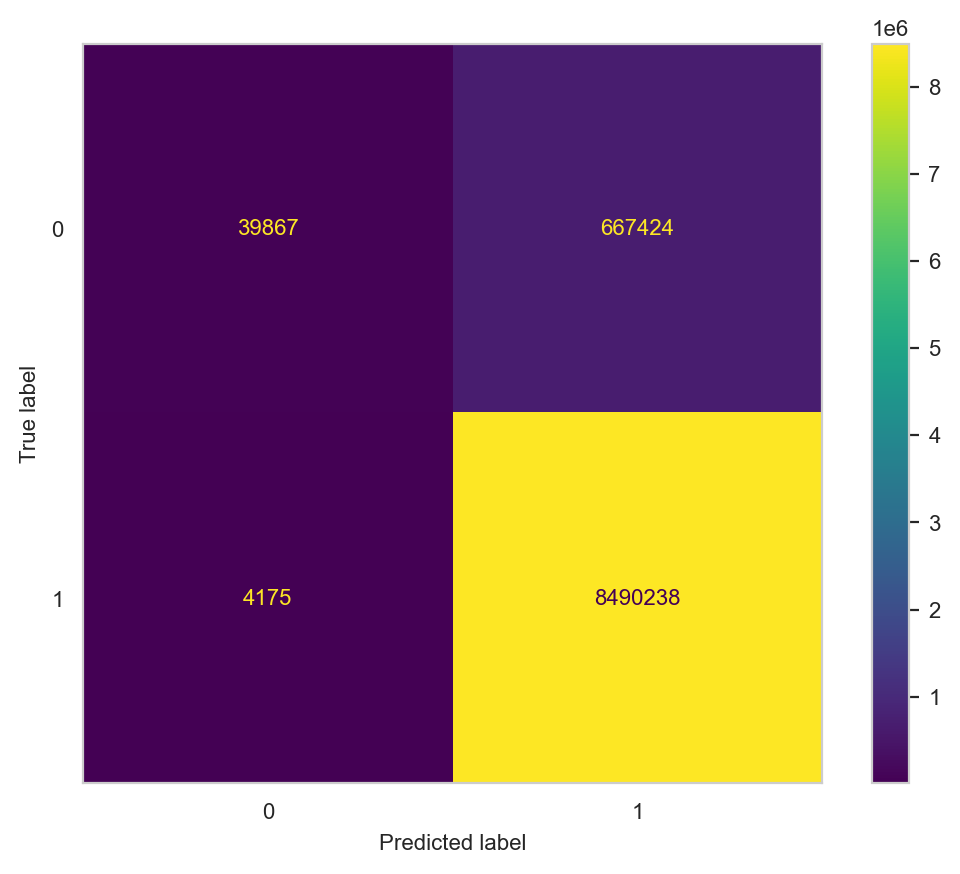

In [47]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_pm, y_oal))
disp.plot(values_format='d')
plt.grid(False)
plt.show()

In [48]:
y_pred = (knn.predict_proba(X_test)[:,1] >= 0.55).astype(bool)

In [49]:
print(classification_report(y_test, y_pred, zero_division=1, target_names=['editorial_discourse', 'research_discourse']))

                     precision    recall  f1-score   support

editorial_discourse       0.64      0.67      0.66    176839
 research_discourse       0.97      0.97      0.97   2123752

           accuracy                           0.95   2300591
          macro avg       0.81      0.82      0.81   2300591
       weighted avg       0.95      0.95      0.95   2300591



In [51]:
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred)

In [52]:
print(auc(fpr, tpr))

0.7967714287481438


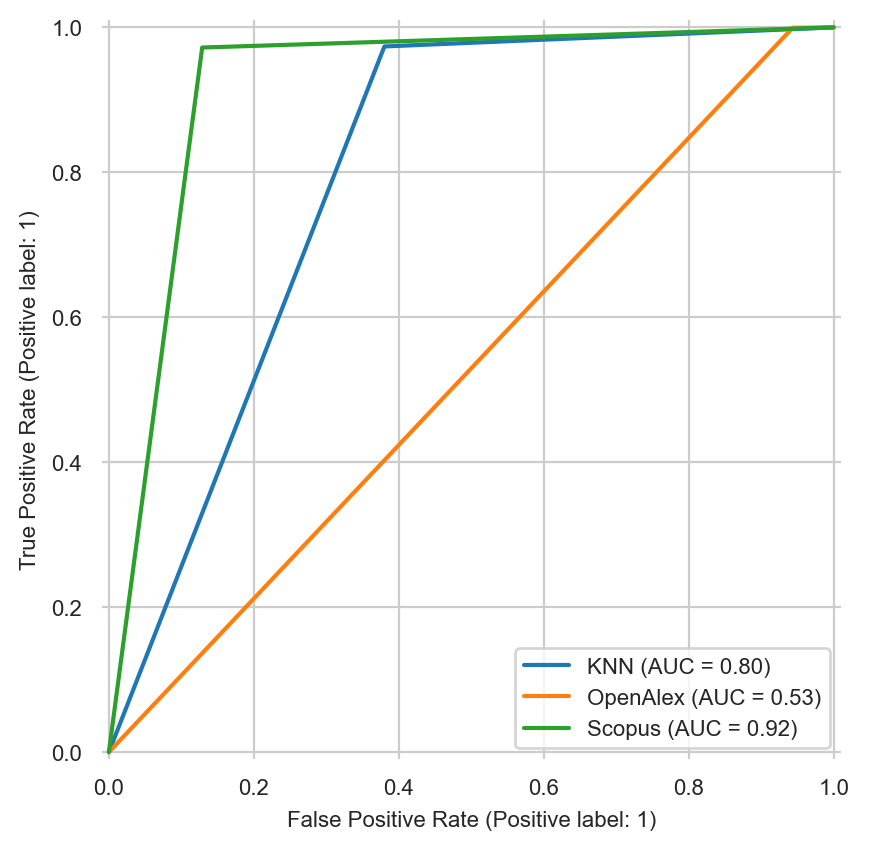

In [53]:
ax = plt.gca()
RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax, name='KNN')
RocCurveDisplay.from_predictions(y_pm, y_oal, ax=ax, name='OpenAlex')
RocCurveDisplay.from_predictions(y_spm, y_scp, ax=ax, name='Scopus')

plt.box(False)

plt.show()

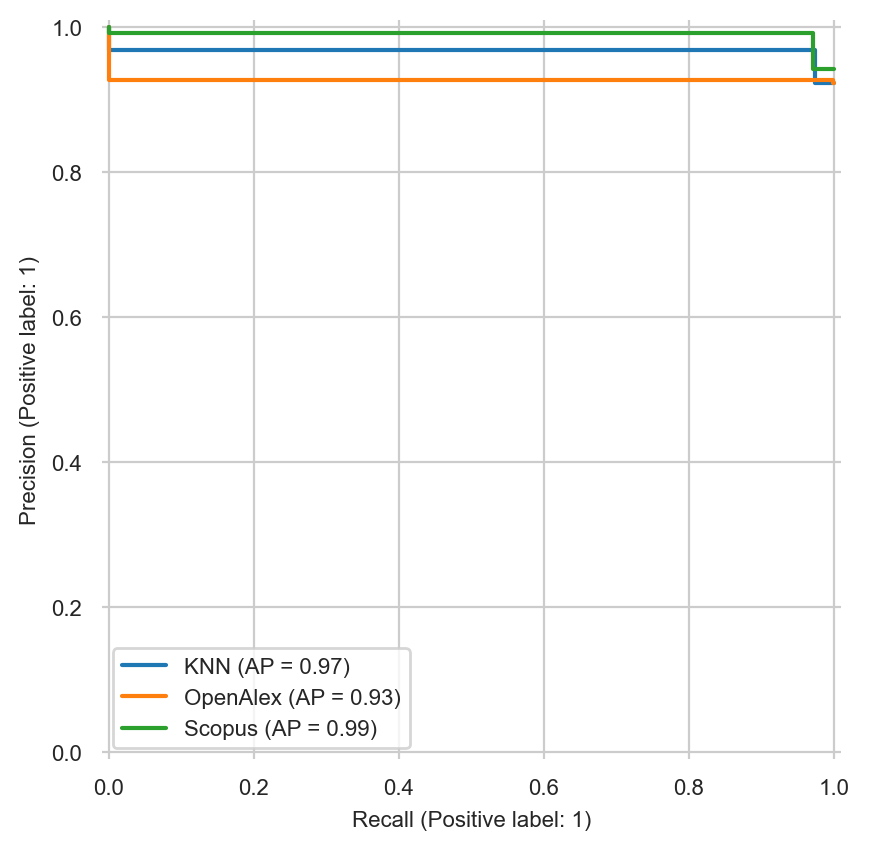

In [54]:
ax = plt.gca()
PrecisionRecallDisplay.from_predictions(y_test, y_pred, ax=ax, name='KNN')
PrecisionRecallDisplay.from_predictions(y_pm, y_oal, ax=ax, name='OpenAlex')
PrecisionRecallDisplay.from_predictions(y_spm, y_scp, ax=ax, name='Scopus')

plt.box(False)

plt.show()

In [55]:
mean_squared_error(y_test, y_pred)

0.053507555232546765

In [56]:
df[df.page_count > 1000].head()

,doi,pm_grouptype,type,abstract,title,page,author_count,has_license,is_referenced_by_count,references_count,has_funder,country_count,has_oa_url,page_count,title_word_length,has_abstract,publisher,n
297813,10.1002/cncr.30009,Journal_Article,1,<jats:sec><jats:title>BACKGROUND</jats:title><...,Comparative effectiveness of stereotactic radi...,2091-100,13,1,50,18,1,1,1,1992,21.0,1,Wiley,983006
353480,10.1002/elps.201200658,Journal_Article,1,<jats:p>Quantitative analysis of site‐specific...,<b><scp>LC‐MS</scp></b>3 quantification of <i>...,2342-4349,4,1,21,28,0,2,1,2008,7.0,1,Wiley,983006
738396,10.1111/cas.14291,Journal_Article,1,NaN,“Abstracts of the 78th Annual Meeting of the J...,1-1208,0,1,0,0,0,1,1,1208,24.0,0,Wiley,983006
1040905,10.1111/ped.13142,Case_Reports,1,<jats:title>Abstract</jats:title><jats:p>Insul...,Double pancreatic tumors in an adolescent: Ima...,1239-12342,5,1,0,12,0,1,0,5000,8.0,1,Wiley,983006
1109588,10.1136/vr.h2941,News,0,<jats:p>The following information has been pro...,Veterinary medicines: product update,614-6614,0,1,0,0,0,1,0,5000,4.0,1,Wiley,983006


In [5]:
page_str = 'e1010.e87-e1019e87'

In [6]:
page_str = re.sub(r'(\.e)[\d]*', '', page_str)
page_str = re.sub(r'(\.)[\d]*', '', page_str)
page_str = re.sub(r'(?<=\d)(e)(\d)*', '', page_str)
page_str = re.sub(r'[^\d-]', '', page_str)

In [7]:
page_str

'1010-1019'

In [23]:
df.head()

,doi,pm_grouptype,type,abstract,title,page,author_count,has_license,is_referenced_by_count,references_count,has_funder,country_count,inst_count,has_oa_url,page_count,title_word_length,has_abstract,publisher,n
0,10.1001/2012.jama.10425,Journal_Article,1,NaN,A Path to Wholeness,985,4,0,1,0,0,1,1,0,1,4,0,American Medical Association (AMA),36486
1,10.1001/2012.jama.10452,Journal_Article,1,NaN,Worries,873,1,0,1,0,0,1,1,0,1,1,0,American Medical Association (AMA),36486
2,10.1001/2012.jama.10500,News,0,NaN,Critics of US House Proposal to Ax AHRQ Say Id...,849,1,0,0,0,0,1,1,0,1,14,0,American Medical Association (AMA),36486
3,10.1001/2012.jama.10931,Editorial,0,NaN,Atherogenic Vascular Stiffness and Hypertension,919,1,0,11,0,0,1,1,0,1,5,0,American Medical Association (AMA),36486
4,10.1001/2012.jama.10939,News,0,NaN,Lessons From Massachusetts: Cost Remains a Hur...,961,1,0,1,0,0,1,1,0,1,12,0,American Medical Association (AMA),36486


In [80]:
test_df['pred'] = y_pred

In [81]:
test_df_with_type = test_df.merge(df[['doi', 'pm_grouptype']], on='doi')

In [82]:
test_df_with_type.groupby(['pm_grouptype', 'pred'])['doi'].agg('count')

pm_grouptype     pred
Case_Reports     0         10116
                 1         53491
CochraneReview   0             3
                 1          1525
Editorial        0         27397
                 1         26298
Journal_Article  0         42584
                 1       1680843
Letter           0         54114
                 1         29856
News             0          4471
                 1          2628
RCT              0           306
                 1         70096
Retraction       0         16370
                 1          5454
Review           0          1431
                 1        210171
SR_and_MA        0           129
                 1         47495
other_53_types   0          5218
                 1          7984
Name: doi, dtype: int64

In [23]:
with open('model.pkl', 'wb') as f:
    pickle.dump(knn, f)